<center> <h1>Homework 4 Solution</h1> </center> 

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import sparse
from sklearn import linear_model
from sklearn.linear_model import LassoCV

In [3]:
ad_heterog  = pd.read_csv('ad_heterog.csv')
ad_heterog .head()

,revenue,treatment,demographic_1,demographic_2,demographic_3,demographic_4,demographic_5,demographic_6,demographic_7,demographic_8,...,demographic_21,demographic_22,demographic_23,demographic_24,demographic_25,demographic_26,demographic_27,demographic_28,demographic_29,demographic_30
0,5.504899,0,1,1,1,0,0,1,1,1,...,1,1,1,1,0,1,1,1,0,1
1,5.554275,1,0,1,1,0,0,0,1,0,...,0,0,0,1,1,0,1,1,1,0
2,5.219492,0,0,1,1,0,0,1,1,1,...,0,1,0,1,0,1,1,0,0,1
3,4.565855,0,1,0,0,0,1,1,0,1,...,1,0,0,1,0,1,0,0,1,0
4,5.020636,0,1,1,0,1,0,0,1,1,...,1,1,0,0,1,1,0,0,0,1


# Part 1: Simple regressions

### Question 1 Answer

In [4]:
simple_reg   = smf.ols(formula = 'revenue ~ treatment', data = ad_heterog).fit()
print(simple_reg .summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     779.2
Date:                Wed, 02 Mar 2022   Prob (F-statistic):          4.50e-145
Time:                        10:20:56   Log-Likelihood:                -1532.5
No. Observations:                2000   AIC:                             3069.
Df Residuals:                    1998   BIC:                             3080.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1082      0.016    315.942      0.0

- Intercept: average revenue for the control group. 

- Coefficient: incremental change in average revenue for treatment group (i.e., showing the ad) compared to the control group (i.e., not showing the ad).

### Question 2 Answer 

No, because (incremental revenue - cost) = 0.65076 - 0.7 < 0.

#  Part 2:  Lasso with interactions

In [5]:
# extract columns pertaining to demographic information (all columns except first two)
demo_matrix = ad_heterog.iloc[:,2:]

# generate interactions of each demographic variable with the treatment variable
demo_treat_matrix = demo_matrix.multiply(ad_heterog['treatment'], axis="index")
demo_treat_matrix.columns = demo_treat_matrix.columns.str.replace("demographic", "treat_demo")

# generate treatment variable that is outside of data-frame (useful below)
treatment = ad_heterog['treatment']

### Question 1 Answer 

In [11]:
# X variables to try for LASSO
X = sparse.csc_matrix(pd.concat([treatment, demo_treat_matrix], axis=1))
# Y variable for LASSO
Y = ad_heterog["revenue"]


# Compute paths
n_alphas = 200
alphas = np.logspace(-4, 0.2, n_alphas)
coefs = []
for a in alphas:
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(X, Y)
    coefs.append(lasso.coef_)


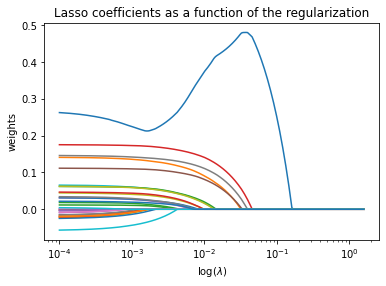

In [12]:
# Display results
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlabel("$\log(\lambda)$")
plt.ylabel("weights")
plt.title("Lasso coefficients as a function of the regularization") 
plt.axis("tight")
plt.show()

The plot (going from right to left) shows how the regression coefficients behave as we lower the penalty parameter lambda. Each line corresponds to a regression coefficient. The first line increases at first, but as we start including the interaction terms, the value of the coefficient becomes smaller. The first line is likely to represent the treatment coefficient. Adding interaction terms changes the interpretation and magnitude of the treatment coefficient. Here this coefficient decreases because the interaction terms have positive coefficients.


Recall interaction terms form Class 5. Consider an example with two demographics (1 and 2). If we have a regression

$$
Y = \beta_0 +\beta_1 Treatment
$$

then $\beta_1 = E[Y|Treatment =1]-E[Y|Treatment =0]$, that is , $\beta_1$ is interpreted as the treatment effect. If we add an interaction term:

$$
Y = \beta_0 +\beta_1 Treatment +\beta_2 Treatment\times demo_1
$$

then 

$$
\beta_1 = E[Y|demo_1=0,Treatment =1]-E[Y|Treatment =0],
$$

and 

$$
\beta_2 = E[Y|demo_1=1,Treatment =1]-E[Y|demo_1=0,Treatment =1]
$$

that is, $\beta_1$ is interpreted as the treatment effect for the demographic 2 with respect to the complete control group; while $\beta_2$ is interpreted as the effect of demographic in the treatment group. 

### Question 2 Answer 

In [15]:
def plot_lassoCV(lasso,nfolds):
     #1se rule 
    mean = np.mean(lasso.mse_path_, axis=1)
    std_error = np.std(lasso.mse_path_, axis=1)/np.sqrt(nfolds)
    mean_min  = mean[lasso.alphas_==lasso.alpha_]
    std_min   = std_error[lasso.alphas_==lasso.alpha_]
    alpha_1se = np.max(lasso.alphas_[mean <= mean_min + std_min])

    # Plot    
    plt.semilogx(lasso.alphas_, np.mean(lasso.mse_path_, axis=1))

    plt.semilogx(lasso.alphas_, mean + std_error, "b--")
    plt.semilogx(lasso.alphas_, mean - std_error, "b--")
    plt.fill_between(lasso.alphas_, mean + std_error, mean - std_error, alpha=0.2)
    plt.axvline(lasso.alpha_, linestyle="--", color="black", label="$\lambda_{min}$")
    plt.axvline(alpha_1se, linestyle="--", color="red", label="$\lambda_{1se}$")
    plt.legend()
    plt.xlabel("$\log(\lambda)$")
    plt.ylabel("Mean Squared Error")
    plt.show() 
    
def get_coef(lasso,scale,coeffnames):
    # getting the coefficients and picking those that are not zero
    coefficients = np.append(lasso.intercept_, lasso.coef_/scale) 
    coeffnames = coeffnames[coefficients != 0]
    coeffvalues = coefficients[coefficients != 0]
    # return non-zero ones 
    return pd.DataFrame([coeffnames, coeffvalues]).T

In [75]:
# We run CV Lasso
nfolds  = 10
lassocv = LassoCV(cv = nfolds, max_iter = 10000)
lassocv.fit(X,Y)

LassoCV(cv=10, max_iter=10000)

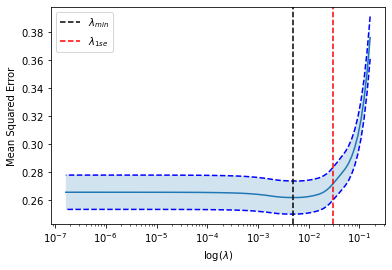

In [47]:
plot_lassoCV(lassocv,nfolds)

In [24]:
coeffnames = list(pd.concat([treatment, demo_treat_matrix], axis=1).columns)
coeffnames.insert(0,'(Intercept)')
coeffnames = np.array(coeffnames)
get_coef(lassocv,1,coeffnames)

,0,1
0,(Intercept),5.117759
1,treatment,0.280851
2,treat_demo_1,0.114795
3,treat_demo_3,0.158607
4,treat_demo_7,0.128264
5,treat_demo_9,0.040007
6,treat_demo_16,0.006887
7,treat_demo_18,0.022377
8,treat_demo_20,0.012228
9,treat_demo_22,0.041163


The results suggest that there is heterogeneity in the treatment effect across different demographics. The differences can be large (for example compare the coefficients for demo 3 and demo 16). This suggests that there may be scope for only showing the ad to a subset of consumers with specific demographic characteristics.


#  Part 3:  Lasso with baseline and interacted demographics

### Question 1 Answer 

In [68]:
# X variables to try for LASSO
X = sparse.csc_matrix(pd.concat([treatment, demo_matrix, demo_treat_matrix], axis=1))

# We run CV Lasso
nfolds  = 10
lassocv = LassoCV(cv = nfolds, max_iter = 10000)
lassocv.fit(X,Y)

LassoCV(cv=10, max_iter=10000)

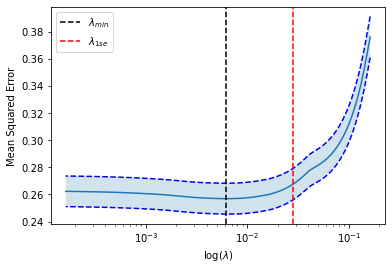

In [69]:
plot_lassoCV(lassocv,nfolds)

In [70]:
coeffnames = list(pd.concat([treatment, demo_matrix, demo_treat_matrix], axis=1).columns)
coeffnames.insert(0,'(Intercept)')
coeffnames = np.array(coeffnames)
get_coef(lassocv,1,coeffnames)

,0,1
0,(Intercept),4.964982
1,treatment,0.454866
2,demographic_1,0.138043
3,demographic_2,-0.002787
4,demographic_7,0.016443
5,demographic_9,0.034156
6,demographic_11,-0.014056
7,demographic_22,0.032252
8,demographic_23,0.020893
9,demographic_25,0.068269


We can only compute the treatment effect for a specific demographic characteristic (that is, the expected revenue for treated individuals with demographic7=1 minus the expected revenue for individuals in the control group with demographic7=1) if we have both interacted and un-interacted terms for that characteristic (i.e., intercept and slope dummy). If we only have the interaction dummy for a certain demographic characteristic, we cannot compute the expected revenue for individuals in the control group with that demographic only.

For example, if we only account for demographic7: 

$$
Y = \beta_0 +\beta_1 Treatment +\beta_2 Treatment\times demo_7 + \beta_3demo_7.
$$

Then, 

$$
E[Y|Treatment=1,demo_7=x]-E[Y|Treatment=0,demo_7=x] = (\beta_0 +\beta_1  +\beta_2 x+ \beta_3x) -
(\beta_0 + \beta_3x)= \beta_1 +\beta_2x\Big |_{x=1} =\beta_1+\beta_2
$$

Note that if $\beta_3=0$ then $E[Y|Treatment=0,demo_7=x] = \beta_0$ which is independent of $x$. That is $\beta_0$ represents $E[Y|Treatment=0]$ and, thefore, we cannot compute the expected revenue for individuals in the control group with demographic7=1.  

### Question 2 Answer 

In [79]:
# X matrix based on all treated
treat_always = (ad_heterog["treatment"] >= 0)  # generates column of ones
demo_treat_always = demo_matrix.multiply(treat_always, axis="index")
demo_treat_always.columns = demo_treat_always.columns.str.replace("demographic", "treat_demo")
X_always = sparse.csc_matrix(pd.concat([treat_always*1,demo_matrix,demo_treat_always], axis=1))

In [81]:
# X matrix based on nobody is treated
treat_never = (ad_heterog["treatment"] < 0)  # generates column of zeros
demo_treat_never = demo_matrix.multiply(treat_never, axis="index")
demo_treat_never.columns = demo_treat_never.columns.str.replace("demographic", "treat_demo")
X_never = sparse.csc_matrix(pd.concat([treat_never*1,demo_matrix,demo_treat_never], axis=1))

In [85]:
# compute revenue at baseline (no treatment) and under treatment for all consumers
ad_heterog["treatment_rev"] = lassocv.predict(X_always)
ad_heterog["baseline_rev"] = lassocv.predict(X_never)

In [87]:
# indicator for who is shown the ad
ad_heterog["showad"] = ad_heterog["treatment_rev"] - ad_heterog["baseline_rev"] > 0.7
np.mean(ad_heterog["showad"])

0.2605

In [89]:
# expected incremental profit without and with targeting
ad_heterog["simple_profit"] = (ad_heterog["treatment_rev"] -ad_heterog["baseline_rev"] - 0.7)
ad_heterog["target_profit"] = (ad_heterog["showad"] *(ad_heterog["treatment_rev"] - ad_heterog["baseline_rev"] - 0.7))

In [90]:
# expected profit per consumer
np.mean(ad_heterog["simple_profit"])

-0.06826410916798252

In [91]:
np.mean(ad_heterog["target_profit"])

0.016132434045402627

Lasso-based targeting results in a positive profit.